In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
from HST_extraction import WavelengthSolution

['/home/mmmurphy/inquiry/hd219666b/reduction', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/mmmurphy/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/mmmurphy/anaconda3/lib/python3.8/site-packages']


In this notebook, I would like to turn the full set of 1D spectra and broadband values into spectral-binned time series. 

Loading in the reduced data, containing the 1D spectra and broadband flux values for each image of each orbit of each visit 3, that I produced in the 'HST Image Reduction' notebook.

In [2]:
# Loading in 1D spectra from each orbit in visit 3
datapath = '/home/mmmurphy/data/hd219666b/reduced_data/'
o1data = np.load(datapath+'orbit1_extractedrawdata.npz')
time_o1 = o1data['times']
spec_o1 = o1data['spectra1D']
errs_o1 = o1data['errs1D']
disp_o1 = np.arange(len(spec_o1[0]))
o2data = np.load(datapath+'orbit2_extractedrawdata.npz')
time_o2 = o2data['times']
spec_o2 = o2data['spectra1D']
errs_o2 = o2data['errs1D']
disp_o2 = np.arange(len(spec_o2[0]))
o3data = np.load(datapath+'orbit3_extractedrawdata.npz')
time_o3 = o3data['times']
spec_o3 = o3data['spectra1D']
errs_o3 = o3data['errs1D']
disp_o3 = np.arange(len(spec_o3[0]))
o4data = np.load(datapath+'orbit4_extractedrawdata.npz')
time_o4 = o4data['times']
spec_o4 = o4data['spectra1D']
errs_o4 = o4data['errs1D']
disp_o4 = np.arange(len(spec_o4[0]))

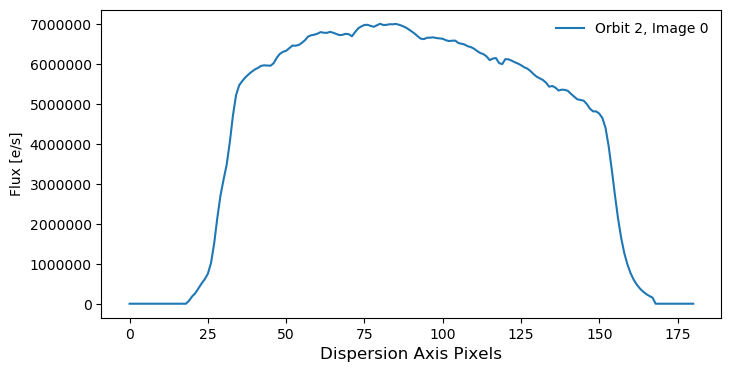

In [3]:
# Plotting an example spectrum, since I like thinking with visuals
plt.figure(figsize=(8,4))
plt.plot(disp_o2, spec_o2[0], label='Orbit 2, Image 0')
plt.xlabel('Dispersion Axis Pixels', fontsize=12)
plt.ylabel('Flux [e/s]')
plt.legend(loc='upper right', frameon=False)
plt.show()

First, I need to find the wavelength calibration in order to transform the dispersion axis from pixels to physical wavelength. I'll do this using a model stellar spectrum as my calibrator. Since the observed spectrum is dominated by the spectrum of the host star, I can align them by picking out notable stellar absorption features. 

HD 219666 is a G7 dwarf star with $T_{eff} = 5527 K$, $log g = 4.38$ in cm/$s^2$, and zero metallicity. I think this is luminosity class V.



The closest thing I can find is a sample G8V star spectrum from https://www.eso.org/sci/facilities/paranal/decommissioned/isaac/tools/lib.html. 

In [4]:
# Opening up the stellar spectrum, which is saved as a fits file
stellarspectrum_file = '/home/mmmurphy/data/hd219666b/calibrations/ukg8v.fits'
ssHDU = fits.open(stellarspectrum_file)
# The fits file stores only the flux
stellarspectrum_flux = ssHDU[0].data
# The corresponding wavelengths are pre-specified
#     Between 1,150 and 25,000 angstroms in uniform 5 angstrom steps
stellarspectrum_wavs = np.arange(1150, 25000+5, 5)   # [Angstrom]

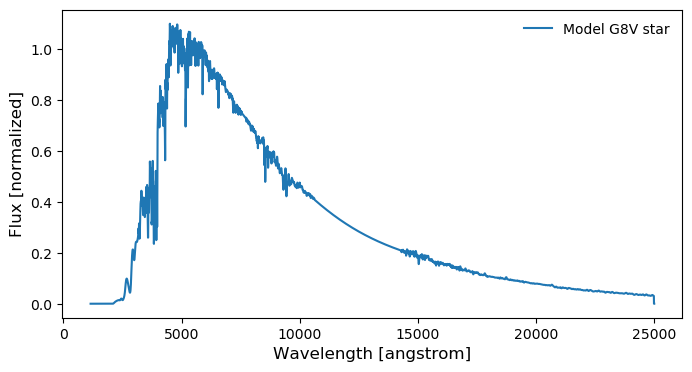

In [7]:
# Looking at the stellar spectrum
plt.figure(figsize=(8,4))
plt.plot(stellarspectrum_wavs, stellarspectrum_flux,
        label='Model G8V star')
plt.xlabel('Wavelength [angstrom]', fontsize=12)
plt.ylabel('Flux [normalized]', fontsize=12)
plt.legend(loc='upper right', frameon=False)
plt.show()

I'm unsure what this spectrum is normalized with respect to, but it doesn't matter for me since I don't need the amplitudes of this model spectrum. I only need the wavelength information. 

Let's crop this down to the WFC3 wavelength range.

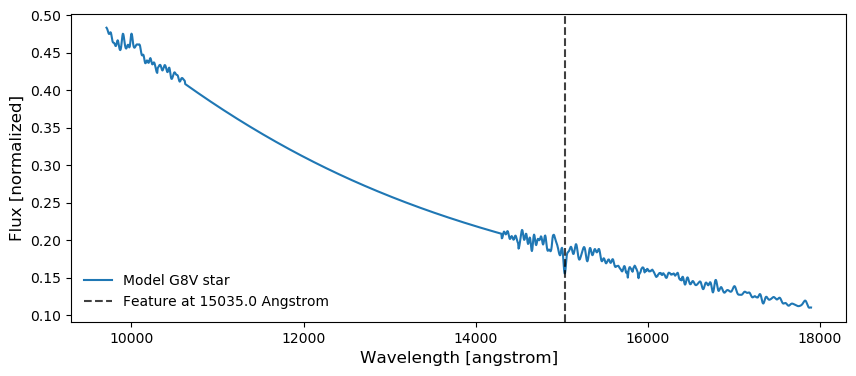

In [8]:
wfc_minwav = 9708 #11250  # [angstrom]
wfc_maxwav = 17904 #16500  # [angstrom]
star_wfc_idxs = np.where((stellarspectrum_wavs >= wfc_minwav) & 
                        (stellarspectrum_wavs <= wfc_maxwav))[0]

# Cropping the spectrum
starwavs = stellarspectrum_wavs[star_wfc_idxs]
starflux = stellarspectrum_flux[star_wfc_idxs]

# In anticipation of what I know I'll see below,
#   finding the array index of the absorption feature near 15,000 angstrom
nearfeature_idxs = np.where((starwavs >= 15000) & (starwavs <= 15100))[0]
nearfeature_fluxes = starflux[nearfeature_idxs]
feature_idx = np.where(nearfeature_fluxes == min(nearfeature_fluxes))[0][0] + nearfeature_idxs[0]
feature_wav = starwavs[feature_idx]  # [angstrom]

# Now plotting the cropped spectrum
plt.figure(figsize=(10,4))
plt.plot(starwavs, starflux, label='Model G8V star')
plt.axvline(feature_wav, ls='--', c='black', alpha=0.75, label='Feature at %.1f Angstrom'%(feature_wav))
plt.xlabel('Wavelength [angstrom]', fontsize=12)
plt.ylabel('Flux [normalized]', fontsize=12)
plt.legend(loc='lower left', frameon=False)
plt.show()

There's a notable feature around 15,035 angstroms that should suffice for calibrating the spectra. Now to try finding it in the observed spectrum.

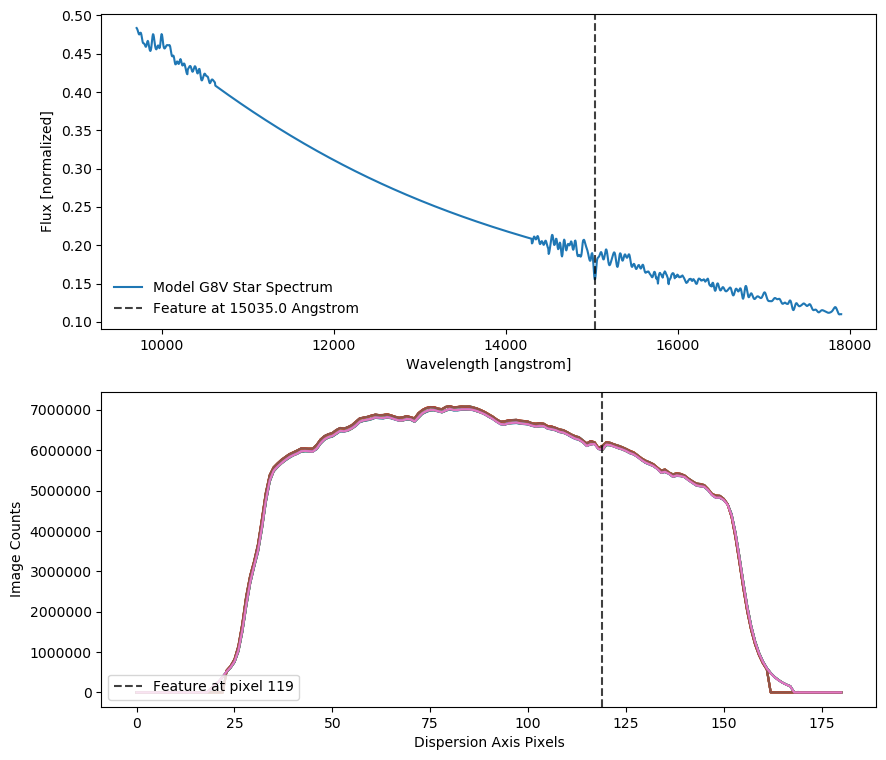

In [16]:
# First plotting the stellar spectrum and feature for comparison
fig, ax = plt.subplots(figsize=(10,9), nrows=2)
ax[0].plot(starwavs, starflux, label='Model G8V Star Spectrum')
ax[0].axvline(feature_wav, ls='--', c='black', alpha=0.75, label='Feature at %.1f Angstrom'%(feature_wav))
ax[0].set_xlabel('Wavelength [angstrom]')
ax[0].set_ylabel('Flux [normalized]')
ax[0].legend(loc='lower left', frameon=False)

# I think I see the feature between pixels 90 and 95 in the observed data
obsnearfeature_fluxes = spec_o2[0][100:120]
feature_pixel = np.where(obsnearfeature_fluxes == min(obsnearfeature_fluxes))[0][0] + 100

for img in range(spec_o2.shape[0]):
    ax[1].plot(disp_o2, spec_o2[img] )
ax[1].axvline(feature_pixel, ls='--', c='black', alpha=0.75, label='Feature at pixel %d'%(feature_pixel))
#ax[1].set_ylim(4.e6)
ax[1].set_xlabel('Dispersion Axis Pixels')
ax[1].set_ylabel('Image Counts')
ax[1].legend(loc='lower left', frameon=True)
plt.show()

Note: also look into the wavelength solution done in my extraction functions

In [41]:
o1directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz205j2q_ima.fits'
o2directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz206jvq_ima.fits'
o3directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz207koq_ima.fits'
o4directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz208lhq_ima.fits'
wsparams_o1 = WavelengthSolution(o1directimg)
full_dispaxis = np.arange(522.0)
waveFunc_o1 = wsparams_o1[0] + wsparams_o1[1]*(full_dispaxis - wsparams_o1[2])
waveInterp = interp1d(waveFunc_o1, full_dispaxis, kind='linear')
# I believe that waveInterp(wavelength in angstrom) returns the pixel value for that wavelength

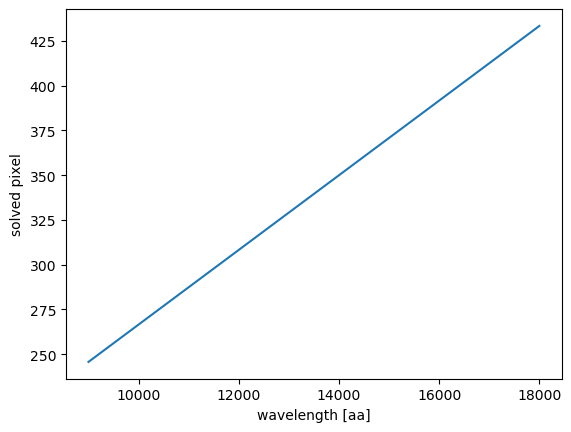

In [42]:
wavs = np.linspace(9000, 18000, 500)
y = waveInterp(wavs)

plt.plot(wavs, y)
plt.xlabel('wavelength [aa]')
plt.ylabel('solved pixel')
plt.show()

I need to figure out what pixels my 2D spectra are at in the full array, since I only know their in-cutout values

In [40]:
waveInterp(13000)

array(329.08730621)

In [34]:
waveFunc_o1

array([-2.77527045e+03, -2.72733402e+03, -2.67939759e+03, -2.63146116e+03,
       -2.58352473e+03, -2.53558830e+03, -2.48765187e+03, -2.43971544e+03,
       -2.39177901e+03, -2.34384258e+03, -2.29590615e+03, -2.24796972e+03,
       -2.20003329e+03, -2.15209687e+03, -2.10416044e+03, -2.05622401e+03,
       -2.00828758e+03, -1.96035115e+03, -1.91241472e+03, -1.86447829e+03,
       -1.81654186e+03, -1.76860543e+03, -1.72066900e+03, -1.67273257e+03,
       -1.62479614e+03, -1.57685971e+03, -1.52892328e+03, -1.48098685e+03,
       -1.43305042e+03, -1.38511399e+03, -1.33717756e+03, -1.28924113e+03,
       -1.24130470e+03, -1.19336828e+03, -1.14543185e+03, -1.09749542e+03,
       -1.04955899e+03, -1.00162256e+03, -9.53686128e+02, -9.05749699e+02,
       -8.57813269e+02, -8.09876840e+02, -7.61940410e+02, -7.14003981e+02,
       -6.66067551e+02, -6.18131122e+02, -5.70194692e+02, -5.22258263e+02,
       -4.74321833e+02, -4.26385404e+02, -3.78448974e+02, -3.30512545e+02,
       -2.82576115e+02, -

In [30]:
wsparams_o1

[8979.605816178528, 47.936429485298476, 245.21801875776467]

I can also use the shape of the observed 1D spectrum pre-calibration to the response function, compared to the shape of the response function, to identify the limiting wavelengths.

In [18]:
# Loading in the G141 response function
file = '/home/mmmurphy/data/calibrations/responsefunctions/HST_WFC3_IR_G141_response.dat'
dat = np.loadtxt(file, unpack=True)
response_wavelength = dat[0]   # wavelength in [AA]
response_value = dat[1]     # response function value
del dat

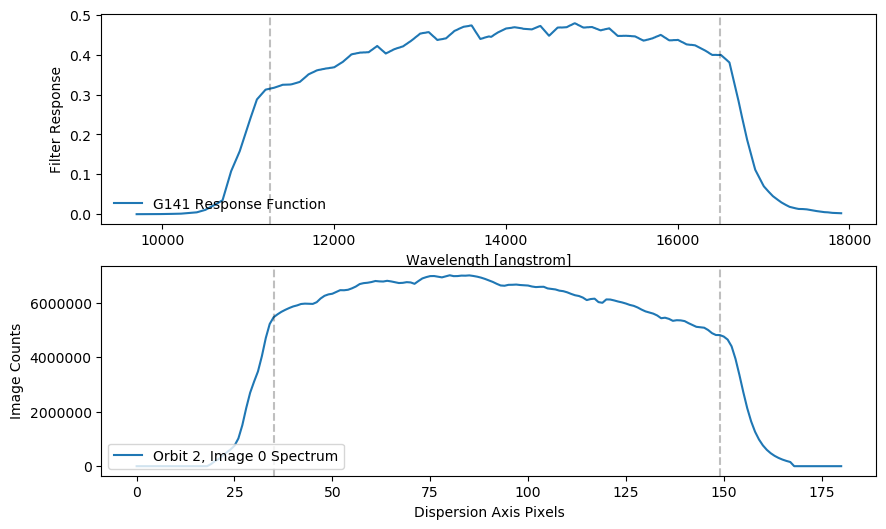

In [25]:
# First plotting the stellar spectrum and feature for comparison
fig, ax = plt.subplots(figsize=(10,6), nrows=2)
ax[0].plot(response_wavelength, response_value, label='G141 Response Function')
#ax[0].axvline(feature_wav, ls='--', c='black', alpha=0.75, label='Feature at %.1f Angstrom'%(feature_wav))
ax[0].set_xlabel('Wavelength [angstrom]')
ax[0].set_ylabel('Filter Response')
ax[0].legend(loc='lower left', frameon=False)
filter_lowlim = 11250
filter_maxlim = 16500
ax[0].axvline(filter_lowlim, c='black', ls='--', alpha=0.25)
ax[0].axvline(filter_maxlim, c='black', ls='--', alpha=0.25)

ax[1].plot(disp_o2, spec_o2[0], label='Orbit 2, Image 0 Spectrum')
obs_lowlim = 35
obs_maxlim = 149
ax[1].axvline(obs_lowlim, c='black', ls='--', alpha=0.25)
ax[1].axvline(obs_maxlim, c='black', ls='--', alpha=0.25)
#ax[1].axvline(feature_pixel, ls='--', c='black', alpha=0.75, label='Feature at pixel %d'%(feature_pixel))
#ax[1].set_ylim(4.e6)
ax[1].set_xlabel('Dispersion Axis Pixels')
ax[1].set_ylabel('Image Counts')
ax[1].legend(loc='lower left', frameon=True)
plt.show()

I have this feature plus knowledge of the limits of the observed spectrum, giving me three data points to do this wavelength calibration with. The observed spectrum's pixel axis should be extended 10 pixels in each direction from what should be the limits of the spectrograph. 

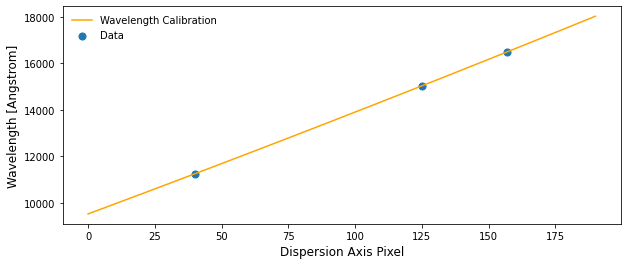

In [10]:
# The 'x' and 'y' of my wavelength calibrations
cal_pixels = np.array([obs_lowlim, feature_pixel, obs_maxlim])
cal_waves = np.array([filter_lowlim, feature_wav, filter_maxlim])

# I'll fit wavelength as a function of pixel using a 2nd-order polynomial
#   wavelength = a * pix^2 + m * pix + b
a, m, b = np.polyfit(cal_pixels, cal_waves, deg=2)
disp_pixels = np.arange(len(exdict['visit3']['orbit2']['spectrum'][0]))
wavelength_calibration = a*(disp_pixels**2) + m*disp_pixels + b

# Now plotting my calibration to check it
plt.figure(figsize=(10,4))
plt.plot(disp_pixels, wavelength_calibration, c='orange', label='Wavelength Calibration')
plt.scatter(cal_pixels, cal_waves, s=50, marker='o', label='Data')
plt.xlabel('Dispersion Axis Pixel', fontsize=12)
plt.ylabel('Wavelength [Angstrom]', fontsize=12)
plt.legend(loc='upper left', frameon=False)
plt.show()

The wavelength calibration creates a function which returns the wavelength when input a pixel number. Therefore, to transform my spectra into being along a wavelength axis, I need only put the pixel axis array into the function.

Since I expanded the extracted pixel/wavelength-axis range to be larger than the actual WFC3 spectral limits, I will cut out the points beyond the spectral limits first. It's worth noting, moreso for my own thoughts, that I don't need to do this for each spectrum. Each spectral image was (or should have been) extracted over the same range of pixels and should cover the same wavelengths. I'll assume this is true until finding otherwise. So, I only need one wavelength array. I will, however, need to cut out the points beyond the wavelength range for each spectrum.

**Important Note:** I'll have to double-check whether or not the summation that created my broadband flux values did or did not include these pixels that are technically off the spectrum, as mentioned above.

Creating a new dictionary to store the calibrated data.

In [11]:
caldict = {
    'visit1':{
        'orbit1':{
            'spectrum':[ [] for _ in range(len(exdict['visit1']['orbit1']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit1']['orbit1']['spectrum']))],
            'broadband':[ 0 for _ in range(len(exdict['visit1']['orbit1']['broadband']))],
            'times':[0 for _ in range(len(exdict['visit1']['orbit1']['broadband']))]},
        'orbit2':{
            'spectrum':[ [] for _ in range(len(exdict['visit1']['orbit2']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit1']['orbit2']['spectrum']))],
            'broadband':[ 0 for _ in range(len(exdict['visit1']['orbit2']['broadband']))],
            'times':[0 for _ in range(len(exdict['visit1']['orbit2']['broadband']))]},
        'orbit3':{
            'spectrum':[ [] for _ in range(len(exdict['visit1']['orbit3']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit1']['orbit3']['spectrum']))],
            'broadband':[ 0 for _ in range(len(exdict['visit1']['orbit3']['broadband']))],
            'times':[0 for _ in range(len(exdict['visit1']['orbit3']['broadband']))]},
        'orbit4':{
            'spectrum':[ [] for _ in range(len(exdict['visit1']['orbit4']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit1']['orbit4']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit1']['orbit4']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit1']['orbit4']['broadband']))]}
    },
   'visit2':{
        'orbit1':{
            'spectrum':[ [] for _ in range(len(exdict['visit2']['orbit1']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit2']['orbit1']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit2']['orbit1']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit1']['orbit1']['broadband']))]},
        'orbit2':{
            'spectrum':[ [] for _ in range(len(exdict['visit2']['orbit2']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit2']['orbit2']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit2']['orbit2']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit2']['orbit2']['broadband']))]},
        'orbit3':{
            'spectrum':[ [] for _ in range(len(exdict['visit2']['orbit3']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit2']['orbit3']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit2']['orbit3']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit2']['orbit3']['broadband']))]},
        'orbit4':{
            'spectrum':[ [] for _ in range(len(exdict['visit2']['orbit4']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit2']['orbit4']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit2']['orbit4']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit2']['orbit4']['broadband']))]}
    },
   'visit3':{
        'orbit1':{
            'spectrum':[ [] for _ in range(len(exdict['visit3']['orbit1']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit3']['orbit1']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit3']['orbit1']['broadband']))],
            'scandirs':[0 for _ in range(len(exdict['visit3']['orbit1']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit3']['orbit1']['broadband']))]},
        'orbit2':{
            'spectrum':[ [] for _ in range(len(exdict['visit3']['orbit2']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit3']['orbit2']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit3']['orbit2']['broadband']))],
            'scandirs':[0 for _ in range(len(exdict['visit3']['orbit2']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit3']['orbit2']['broadband']))]},
        'orbit3':{
            'spectrum':[ [] for _ in range(len(exdict['visit3']['orbit3']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit3']['orbit3']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit3']['orbit3']['broadband']))],
            'scandirs':[0 for _ in range(len(exdict['visit3']['orbit3']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit3']['orbit3']['broadband']))]},
        'orbit4':{
            'spectrum':[ [] for _ in range(len(exdict['visit3']['orbit4']['spectrum']))],
            'binnedspectrum':[ [] for _ in range(len(exdict['visit3']['orbit4']['spectrum']))],
            'times':[0 for _ in range(len(exdict['visit3']['orbit4']['broadband']))],
            'scandirs':[0 for _ in range(len(exdict['visit3']['orbit4']['broadband']))],
            'broadband':[ 0 for _ in range(len(exdict['visit3']['orbit4']['broadband']))]}
    },
    'wavelengths':np.asarray([]),
    'binnedwavelengths':np.asarray([])
}

In [12]:
# My wavelength array is 'wavelength_calibration'
idxs_beyond_range = np.where((wavelength_calibration < wfc_minwav) | 
                            (wavelength_calibration > wfc_maxwav))[0]
# Deleting the out-of-range wavelength points from my wavelength array
#   (and storing the only in-range ones to this new array)
good_wavelengths = np.delete(wavelength_calibration, idxs_beyond_range)
# Adding these to my new dictionary
caldict['wavelengths'] = good_wavelengths

for orbit in exdict['visit3']:
    # Looping through each orbit in visit 3
    for i, image in enumerate(exdict['visit3'][orbit]['spectrum']):
        # Looping through each 1D spectrum image in this orbit
        #   note that these images form a time-series
        # Getting the image's spectrum, by index just to make sure
        spectrum1D = exdict['visit3'][orbit]['spectrum'][i]
        # Cutting out the out-of-range points
        spec1D_goodpoints = np.delete(spectrum1D, idxs_beyond_range)
        # Adding to the calibrated data dictionary
        caldict['visit3'][orbit]['spectrum'][i] = spec1D_goodpoints
    for image in exdict['visit3'][orbit]['broadband']:
        # Also looping through the broadband images
        #   to pass their data through to the new array
        caldict['visit3'][orbit]['broadband'][i] = image

Now I need to worry about the filter response. 

The response function won't be aligned with my spectra's wavelength array, so I'll use an interpolation routine to generate an interpolated response function at the matching wavelengths.

In [13]:
response_func_interpolator = interp1d(response_wavelength, response_value)
interp_response_value = response_func_interpolator(good_wavelengths)

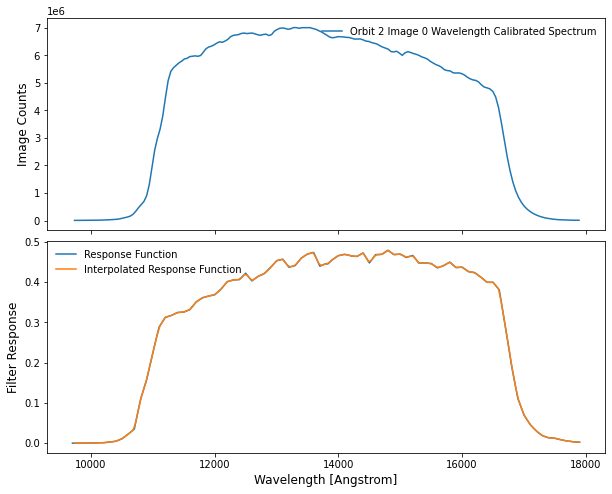

In [14]:
# Plotting one calibrated 1d spectrum to get a visual
#   along with the response function
fig, ax = plt.subplots(figsize=(10,8), nrows=2, sharex=True)
plt.subplots_adjust(hspace=0.05)
testspec = caldict['visit3']['orbit2']['spectrum'][0]

ax[0].plot(good_wavelengths, testspec, label='Orbit 2 Image 0 Wavelength Calibrated Spectrum')
ax[0].set_ylabel('Image Counts', fontsize=12)
ax[0].legend(loc='upper right', frameon=False)

ax[1].plot(response_wavelength, response_value, label='Response Function')
ax[1].plot(good_wavelengths, interp_response_value, label='Interpolated Response Function')
ax[1].legend(loc='upper left', frameon=False)
ax[1].set_ylabel('Filter Response', fontsize=12)
ax[1].set_xlabel('Wavelength [Angstrom]', fontsize=12)

plt.show()

Now applying the interpolated response function.

First, a test:

In [15]:
calspec = testspec / interp_response_value

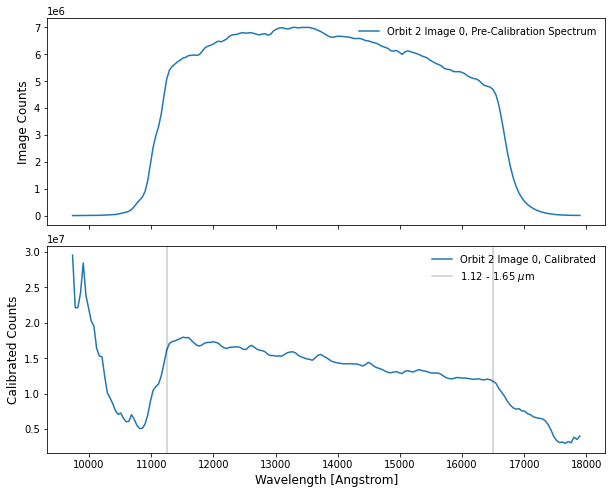

In [16]:
# Plotting one calibrated 1d spectrum to get a visual
#   compare to uncalibrated
fig, ax = plt.subplots(figsize=(10,8), nrows=2, sharex=True)
plt.subplots_adjust(hspace=0.1)

ax[0].plot(good_wavelengths, testspec, label='Orbit 2 Image 0, Pre-Calibration Spectrum')
ax[0].set_ylabel('Image Counts', fontsize=12)
ax[0].legend(loc='upper right', frameon=False)

ax[1].plot(good_wavelengths, calspec, label='Orbit 2 Image 0, Calibrated')
ax[1].set_ylabel('Calibrated Counts', fontsize=12)
ax[1].set_xlabel('Wavelength [Angstrom]', fontsize=12)
ax[1].axvline(11250, c='black', alpha=0.2, label=r'1.12 - 1.65 $\mu$m')
ax[1].axvline(16500, c='black', alpha=0.2)
ax[1].legend(loc='upper right', frameon=False)


plt.show()

**NOTE**: I'm note sure how to apply the response function to the broadband values unless I (a) re-compute the broadband stuff here or (b) add the response function into my image reduction pipeline

In [17]:
for orbit in caldict['visit3']:
    # Looping through each orbit in visit 3
    for i, image in enumerate(caldict['visit3'][orbit]['spectrum']):
        # Looping through each 1D spectrum image in this orbit
        #   note that these images form a time-series
        # Getting the image's spectrum, by index just to make sure
        uncal_spectrum = caldict['visit3'][orbit]['spectrum'][i]
        # Calibrating...
        caldict['visit3'][orbit]['spectrum'][i] = uncal_spectrum / interp_response_value
#     for image in exdict['visit3'][orbit]['broadband']:
#         # Also looping through the broadband images
#         #   to pass their data through to the new array
#         caldict['visit3'][orbit]['broadband'][i] = image

Now onto the binning! Convention dictates that these spectra are binned down to only 15-16 points along the wavelength axis. Since the spectral range here is relatively small, I don't need to worry about doing this binning strictly properly (i.e. keeping the bins uniformly sized in log-space) and can just space them linearly. 

In [35]:
def bindata(x_data, y_data, binedges):
    bin_xs = [ [] for _ in range(len(binedges)) ]
    bin_ys = [ [] for _ in range(len(binedges)) ]
    for i, xvalue in enumerate(x_data):
        if xvalue < binedges[0]:
            continue
        elif xvalue > binedges[-1]:
            continue
        current_bin = np.searchsorted(binedges, xvalue, side='left') 
        bin_xs[current_bin].append(x_data[i])
        bin_ys[current_bin].append(y_data[i])
        #print(current_bin)
        
    bin_xarr = np.asarray([])
    bin_yarr = np.asarray([])
    for j, byn in enumerate(bin_xs):
        bin_xvalue = np.median(bin_xs[j])
        bin_xarr = np.append(bin_xarr, bin_xvalue)
        
        bin_yvalue = np.median(bin_ys[j])
        bin_yarr = np.append(bin_yarr, bin_yvalue)
        
    return bin_xarr, bin_yarr

In [36]:
# Defining the number of bins to use
Nbins = 15
# Creating the bin boundaries
bins = np.linspace(start=11250, stop=16500, num=Nbins,
                  endpoint=True)

/home/matthew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matthew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


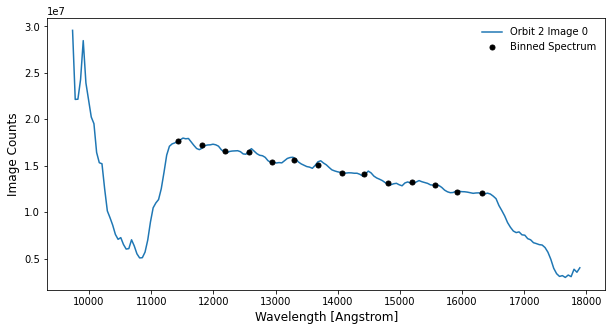

In [37]:
# Plotting one calibrated 1d spectrum to get a visual
#   and start planning the spectral binning
fig, ax = plt.subplots(figsize=(10,5))

testspec = caldict['visit3']['orbit2']['spectrum'][0]
wavs_b, spec_b = bindata(good_wavelengths, testspec, bins)

ax.plot(good_wavelengths, testspec, label='Orbit 2 Image 0')
ax.scatter(wavs_b, spec_b, marker='o', s=25, zorder=5, color='black', label='Binned Spectrum')
ax.set_xlabel('Wavelength [Angstrom]', fontsize=12)
ax.set_ylabel('Image Counts', fontsize=12)
ax.legend(loc='upper right', frameon=False)
plt.show()

In [38]:
wavs_b

array([           nan, 11424.6510181 , 11818.86764706, 12192.77757353,
       12568.22822398, 12945.23029789, 13301.46559201, 13681.4635181 ,
       14063.01286765, 14423.5279506 , 14808.07315234, 15194.16977753,
       15558.96464932, 15925.12905354, 16315.67665913])

(6750000.0, 7200000.0)

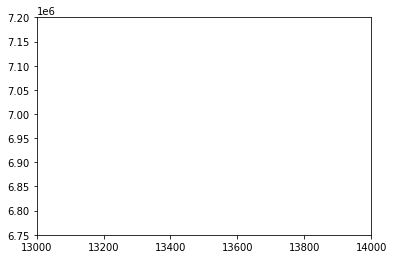

In [22]:
plt.plot(good_wavelengths, caldict['visit3']['orbit2']['spectrum'][0], c='blue')
plt.plot(good_wavelengths, caldict['visit3']['orbit3']['spectrum'][0], c='orange')
plt.plot(good_wavelengths, caldict['visit3']['orbit4']['spectrum'][0], c='green')
plt.xlim((13000, 14000))
plt.ylim((6.75e6, 7.2e6))

Now binning all of the spectra...

In [23]:
# Binning the wavelength array, as I only need to do this once
waves_b, void = bindata(good_wavelengths, testspec, bins)
# Adding these to my new dictionary
caldict['binnedwavelengths'] = waves_b

for orbit in caldict['visit3']:
    # Looping through each orbit in visit 3
    for i, image in enumerate(caldict['visit3'][orbit]['spectrum']):
        # Looping through each 1D spectrum image in this orbit
        # Getting the image's spectrum, by index just to make sure
        spectrum1D = caldict['visit3'][orbit]['spectrum'][i]
        # Binning it
        void, spec1D_b = bindata(good_wavelengths, spectrum1D, bins)
        # Adding to the calibrated data dictionary
        caldict['visit3'][orbit]['binnedspectrum'][i] = spec1D_b

In [24]:
waves_b

array([ 9736.40837104, 10037.0296003 , 10598.10803167, 11184.59681373,
       11774.98020362, 12347.18608597, 12923.00838989, 13502.44711538,
       14085.50226244, 14672.17383107, 15262.46182127, 15856.36623303,
       16430.84129902, 17008.6546003 , 17613.1300905 ])

(6750000.0, 7200000.0)

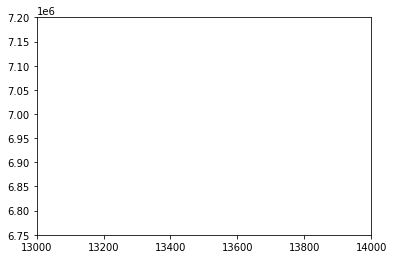

In [25]:
plt.scatter(waves_b, caldict['visit3']['orbit2']['binnedspectrum'][3], c='blue')
plt.scatter(waves_b, caldict['visit3']['orbit3']['binnedspectrum'][3], c='orange')
plt.scatter(waves_b, caldict['visit3']['orbit4']['binnedspectrum'][3], c='green')
plt.xlim((13000, 14000))
plt.ylim((6.75e6, 7.2e6))

Once again, these are time-series. I didn't port the image times through, but I can just get those easily from the images themselves.

In [26]:
from astropy.io import fits       # Need this to open the fits files
from HST_Extract_Funcs import CreateSubExps, WavelengthSolution  # Used to pull image data

In [27]:
# I need to loop through all the images, get the times of each of their sub-exposures
#   and then average them to get the image's time

# First loading in the data paths to the image files
FPload = np.load('FilePaths.npz', allow_pickle=True)
datapaths = FPload['filedict'].item()   # dictionary containing paths to the image files
del FPload

for orbit in datapaths['visit3']:
    # Going through each orbit in the visit
    Nimages = len(datapaths['visit3'][orbit]['grism'])
    orbits_imagetimes = np.zeros(Nimages)
    directimage_path = datapaths['visit3'][orbit]['direct']
    wavesolution = WavelengthSolution(directimage_path)
    
    for image in range(Nimages):

        subexposure_details = CreateSubExps(datapaths['visit3'][orbit]['grism'][image], wavesolution)
        subexposure_times = subexposure_details[1]
        image_scandir = subexposure_details[4]
        image_time = np.median(subexposure_times)
        
        caldict['visit3'][orbit]['times'][image] = image_time
        caldict['visit3'][orbit]['scandirs'][image] = image_scandir

## Comparing to Thomas' reduction 

In [28]:
# Loading in Thomas' reduction results
# These are post-image reduction, post-spectral binning
# These are the time series for each wavelength bin, un-normalized by scan direction
Tfile = np.load('/home/matthew/data/hd219666b/thomas_results/Transit_Spectra_NoFirst_Visit3.npz', allow_pickle=True)
time_T = Tfile['time']
flux_T = Tfile['flux']         # this flux is un-normalized

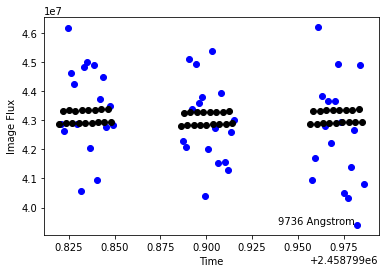

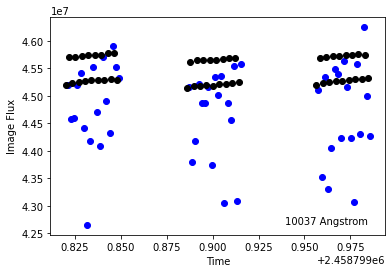

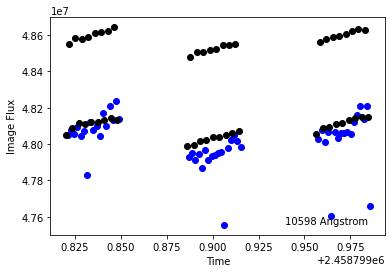

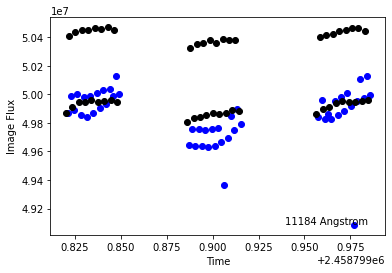

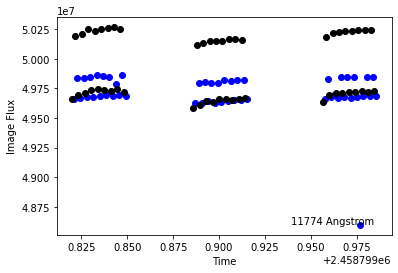

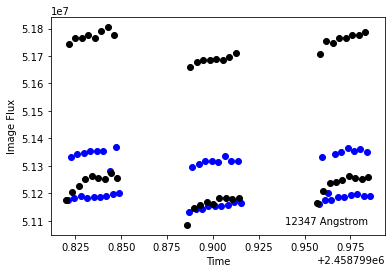

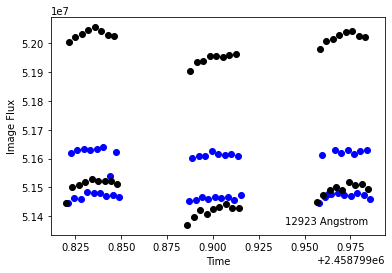

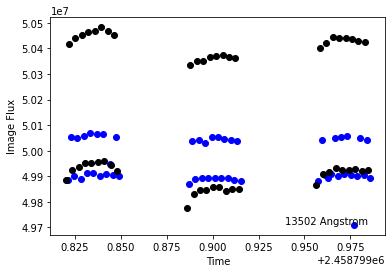

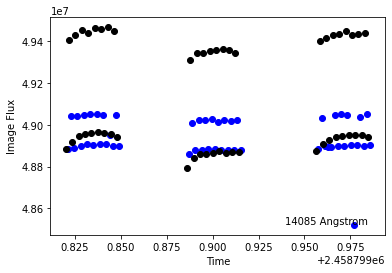

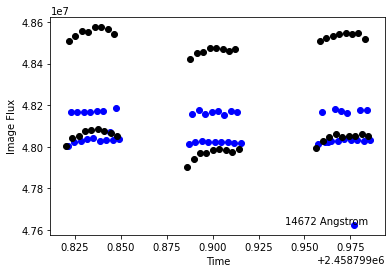

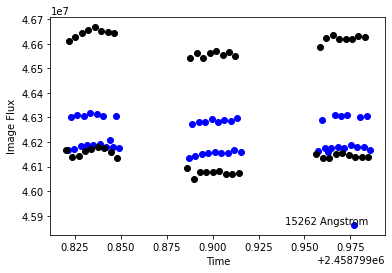

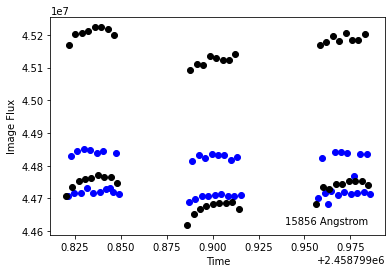

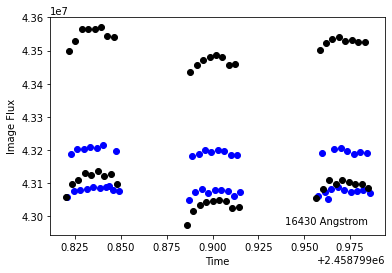

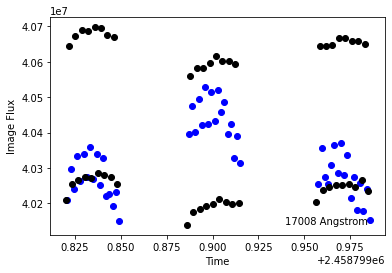

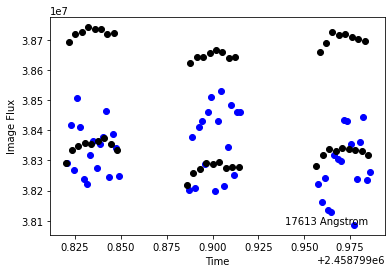

In [29]:

for wavebin in range(15):

    t_o2 = caldict['visit3']['orbit2']['times']
    t_o3 = caldict['visit3']['orbit3']['times']
    t_o4 = caldict['visit3']['orbit4']['times']

    yo2 = np.zeros(len(t_o2))
    for i, img in enumerate(caldict['visit3']['orbit2']['binnedspectrum']):
        yo2[i] = img[wavebin]
    yo3 = np.zeros(len(t_o3))
    for i, img in enumerate(caldict['visit3']['orbit3']['binnedspectrum']):
        yo3[i] = img[wavebin]
    yo4 = np.zeros(len(t_o4))
    for i, img in enumerate(caldict['visit3']['orbit4']['binnedspectrum']):
        yo4[i] = img[wavebin]

    fig, ax = plt.subplots()
    offset = flux_T[wavebin, 0] - yo2[0]
    plt.scatter(t_o2, yo2+offset, c='blue')
    plt.scatter(t_o3, yo3+offset, c='blue')
    plt.scatter(t_o4, yo4+offset, c='blue')


    plt.scatter(time_T, flux_T[wavebin,:], c='black')
    plt.xlabel('Time')
    plt.ylabel('Image Flux')
    plt.text(0.7, 0.05, '%d Angstrom'%(waves_b[wavebin]), transform=ax.transAxes)
    plt.show()

In [30]:
len(caldict['visit3']['orbit2']['times'][:])

17

In [31]:
len(caldict['visit3']['orbit2']['binnedspectrum'][wavebin])

15

ValueError: x and y must be the same size

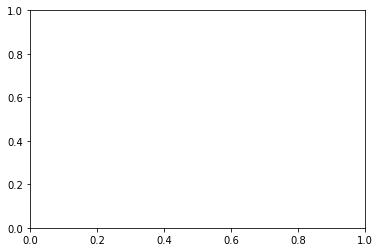

In [32]:
for wavebin in range(15):
    t = np.concatenate((caldict['visit3']['orbit2']['times'][:],
                        caldict['visit3']['orbit3']['times'][:],
                        caldict['visit3']['orbit4']['times'][:]))
    tT = time_T
    
    y = np.zeros(len(t))
    for img in caldict['visit3']['orbit2']['binnedspectrum']:
        y = np.append(y, img[wavebin])
    yT = flux_T[wavebin,:]
    
    plt.scatter(t, y, c='blue', s=5)
    plt.scatter(tT, yT, c='black', s=5)
    plt.show()
    

In [ ]:
len(t)

In [ ]:
len(y)

In [ ]:
y

In [ ]:
len(t_o2)

In [ ]:
yo2

In [ ]:
wavebin = 4
t_o2 = caldict['visit3']['orbit2']['times']
t_o3 = caldict['visit3']['orbit3']['times']
t_o4 = caldict['visit3']['orbit4']['times']

yo2 = np.zeros(len(t_o2))
for i, img in enumerate(caldict['visit3']['orbit2']['binnedspectrum']):
    yo2[i] = img[wavebin]
yo3 = np.zeros(len(t_o3))
for i, img in enumerate(caldict['visit3']['orbit3']['binnedspectrum']):
    yo3[i] = img[wavebin]
yo4 = np.zeros(len(t_o4))
for i, img in enumerate(caldict['visit3']['orbit4']['binnedspectrum']):
    yo4[i] = img[wavebin]

plt.scatter(t_o2, yo2)
plt.scatter(t_o3, yo3)
plt.scatter(t_o4, yo4)

In [ ]:
# Plotting a sample time series
wavebin = 1
t_o2 = caldict['visit3']['orbit2']['times']
t_o3 = caldict['visit3']['orbit3']['times']
t_o4 = caldict['visit3']['orbit4']['times']

sd_o2 = np.asarray(caldict['visit3']['orbit2']['scandirs'])
sd_o3 = np.asarray(caldict['visit3']['orbit3']['scandirs'])
sd_o4 = np.asarray(caldict['visit3']['orbit4']['scandirs'])

y_o2 = np.asarray([])
y_o3 = np.asarray([])
y_o4 = np.asarray([])

for img in caldict['visit3']['orbit2']['binnedspectrum']:
    y_o2 = np.append(y_o2, img[wavebin])
s0_o2_idxs = np.where(sd_o2 == 0)
s1_o2_idxs = np.where(sd_o2 == 1)

s0med_o2 = np.mean(y_o2[s0_o2_idxs])
s1med_o2 = np.mean(y_o2[s1_o2_idxs])
yy_o2 = np.zeros(len(y_o2))
for i, val in enumerate(y_o2):
    if sd_o2[i] == 0:
        yy_o2[i] = val / s0med_o2
    elif sd_o2[i] == 1:
        yy_o2[i] = val / s1med_o2
    
for img in caldict['visit3']['orbit3']['binnedspectrum']:
    y_o3 = np.append(y_o3, img[wavebin])
    
s0_o3_idxs = np.where(sd_o3 == 0)
s1_o3_idxs = np.where(sd_o3 == 1)

s0med_o3 = np.mean(y_o3[s0_o3_idxs])
s1med_o3 = np.mean(y_o3[s1_o3_idxs])
yy_o3 = np.zeros(len(y_o3))
for i, val in enumerate(y_o3):
    if sd_o3[i] == 0:
        yy_o3[i] = val / s0med_o2
    elif sd_o3[i] == 1:
        yy_o3[i] = val / s1med_o2
    
for img in caldict['visit3']['orbit4']['binnedspectrum']:
    y_o4 = np.append(y_o4, img[wavebin])
    
s0_o4_idxs = np.where(sd_o4 == 0)
s1_o4_idxs = np.where(sd_o4 == 1)

s0med_o4 = np.mean(y_o4[s0_o4_idxs])
s1med_o4 = np.mean(y_o4[s1_o4_idxs])
yy_o4 = np.zeros(len(y_o4))
for i, val in enumerate(y_o4):
    if sd_o4[i] == 0:
        yy_o4[i] = val / s0med_o2
    elif sd_o4[i] == 1:
        yy_o4[i] = val / s1med_o2
        
plt.scatter(t_o2, yy_o2)
plt.scatter(t_o3, yy_o3)
plt.scatter(t_o4, yy_o4)
plt.axhline(1., c='black', alpha=0.5)
plt.axhline(1. - (0.0419)**2, c='black', alpha=0.5)
plt.ylim((0.995, 1.005))

In [ ]:
# Comparing to what Thomas got
Tfile = np.load('/home/matthew/data/hd219666b/thomas_results/Transit_Spectra_NoFirst_Visit3.npz', allow_pickle=True)
time_T = Tfile['time']
flux_T = Tfile['flux']         # this flux is un-normalized
scandir_T = Tfile['scandir']

scan0idx = np.where(scandir_T == 0)
scan1idx = np.where(scandir_T == 1)

Tflux_b = np.copy(flux_T)

for wav in range(Tflux_b.shape[0]):
    f = flux_T[wav,:]
    
    f_scan0 = f[scan0idx]
    f_scan1 = f[scan1idx]
    
    # Using last orbit median since that is fully out-of-transit
    s0med = np.median(f_scan0[16:])
    s1med = np.median(f_scan1[18:])
    
    for i in range(Tflux_b.shape[1]):
        if (scandir_T[i] == 0):
            Tflux_b[wav, i] = f[i] / s0med
        elif (scandir_T[i] == 1):
            Tflux_b[wav, i] = f[i] / s1med

In [ ]:
plt.scatter(time_T, flux_T[0,:])
